Using device: cuda


C:\Users\vishal kumar\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\vishal kumar\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1: Train Loss=1.0556, Train Acc=0.5945 | Val Loss=0.8721, Val Acc=0.6588
Epoch 2: Train Loss=0.9069, Train Acc=0.6559 | Val Loss=0.8092, Val Acc=0.7132
Epoch 3: Train Loss=0.8462, Train Acc=0.6714 | Val Loss=0.7782, Val Acc=0.6951
Epoch 4: Train Loss=0.7942, Train Acc=0.6873 | Val Loss=0.8988, Val Acc=0.6860
Epoch 5: Train Loss=0.7796, Train Acc=0.6995 | Val Loss=0.8175, Val Acc=0.6770
Epoch 6: Train Loss=0.7255, Train Acc=0.7145 | Val Loss=0.7203, Val Acc=0.7187
Epoch 7: Train Loss=0.6914, Train Acc=0.7227 | Val Loss=0.7365, Val Acc=0.7005
Epoch 8: Train Loss=0.6843, Train Acc=0.7332 | Val Loss=0.7427, Val Acc=0.7205
Epoch 9: Train Loss=0.6740, Train Acc=0.7400 | Val Loss=0.7312, Val Acc=0.7296
Epoch 10: Train Loss=0.6522, Train Acc=0.7418 | Val Loss=0.7566, Val Acc=0.7060
Epoch 11: Train Loss=0.6546, Train Acc=0.7445 | Val Loss=0.7172, Val Acc=0.7387
Epoch 12: Train Loss=0.6187, Train Acc=0.7564 | Val Loss=0.7248, Val Acc=0.7169
Epoch 13: Train Loss=0.6128, Train Acc=0.7505 | V

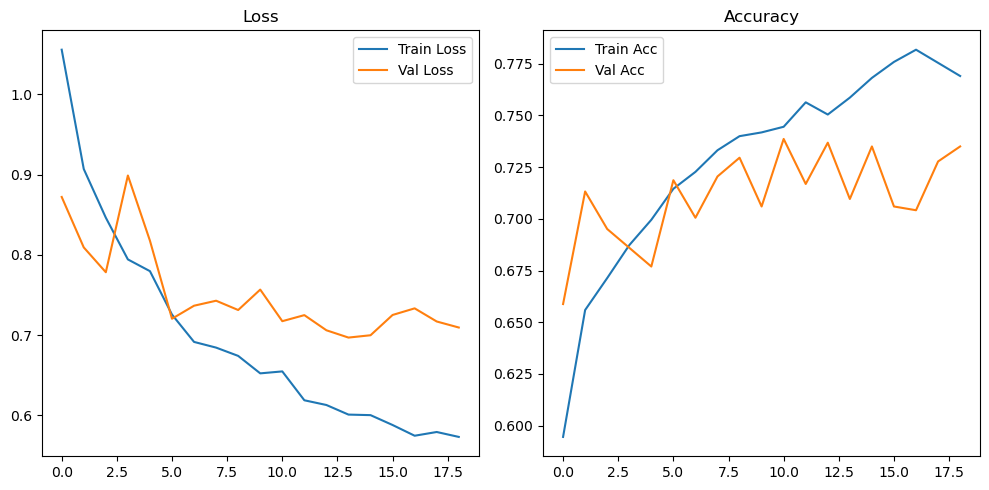


Classification Report:
                precision    recall  f1-score   support

       Healthy       0.91      0.99      0.95       203
       Mild DR       0.53      0.59      0.56        70
   Moderate DR       0.64      0.74      0.69       184
Proliferate DR       0.40      0.15      0.22        53
     Severe DR       0.57      0.32      0.41        41

      accuracy                           0.72       551
     macro avg       0.61      0.56      0.56       551
  weighted avg       0.70      0.72      0.70       551



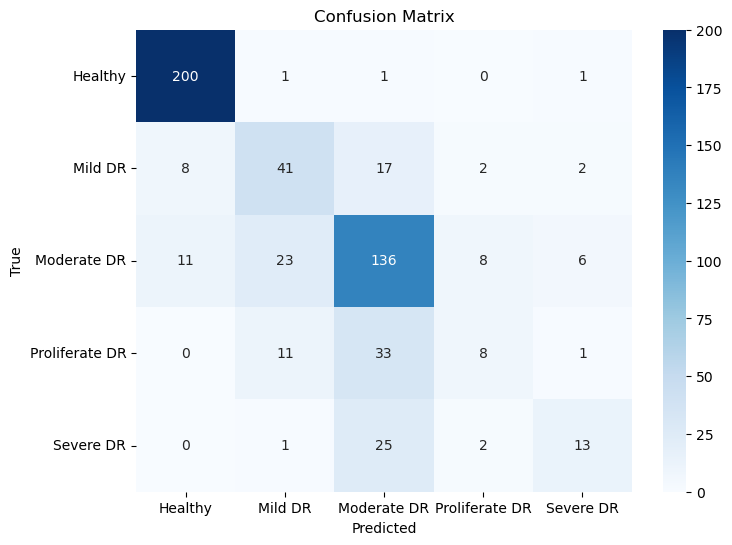

Predicted Class: Severe DR


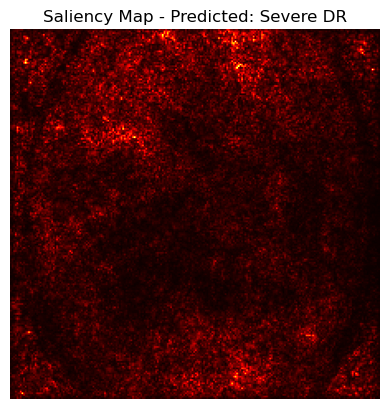

In [1]:
#code 1 saliency map
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from PIL import Image
import numpy as np

# Paths
data_dir = r"C:\Users\vishal kumar\Desktop\dataset\diabetic retinopathy"
model_save_path = "vgg16_best_model.pth"

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Dataset
full_dataset = datasets.ImageFolder(data_dir, transform=transform)
class_names = full_dataset.classes

# Split
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2, pin_memory=True)

# Load pretrained VGG16
model = models.vgg16(pretrained=True)
for param in model.features.parameters():
    param.requires_grad = False

# Custom classifier
model.classifier = nn.Sequential(
    nn.Linear(25088, 4096),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(4096, 1024),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024, 5)
)
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# Training loop
best_val_loss = float('inf')
patience, counter = 5, 0
train_loss_list, val_loss_list = [], []
train_acc_list, val_acc_list = [], []

for epoch in range(25):
    model.train()
    train_loss, correct, total = 0.0, 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    avg_train_loss = train_loss / total
    avg_train_acc = correct / total
    train_loss_list.append(avg_train_loss)
    train_acc_list.append(avg_train_acc)

    # Validation
    model.eval()
    val_loss, val_correct = 0.0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()

    avg_val_loss = val_loss / len(test_loader.dataset)
    avg_val_acc = val_correct / len(test_loader.dataset)
    val_loss_list.append(avg_val_loss)
    val_acc_list.append(avg_val_acc)

    print(f"Epoch {epoch+1}: Train Loss={avg_train_loss:.4f}, Train Acc={avg_train_acc:.4f} | Val Loss={avg_val_loss:.4f}, Val Acc={avg_val_acc:.4f}")
    scheduler.step()

    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), model_save_path)
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break

# Load best model
model.load_state_dict(torch.load(model_save_path))
model.eval()

# Plot Loss and Accuracy
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(train_loss_list, label="Train Loss")
plt.plot(val_loss_list, label="Val Loss")
plt.title("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_acc_list, label="Train Acc")
plt.plot(val_acc_list, label="Val Acc")
plt.title("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

# Classification Report
y_true, y_pred = [], []
model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(preds.cpu().numpy())

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Saliency Map Function
def show_saliency_map(model, image_tensor):
    model.eval()
    image_tensor = image_tensor.unsqueeze(0).to(device).requires_grad_()
    output = model(image_tensor)
    pred_class = output.argmax().item()
    output[0, pred_class].backward()

    saliency, _ = torch.max(image_tensor.grad.data.abs(), dim=1)
    saliency = saliency.squeeze().cpu().numpy()

    plt.imshow(saliency, cmap='hot')
    plt.axis('off')
    plt.title(f"Saliency Map - Predicted: {class_names[pred_class]}")
    plt.show()

# Predict on sample image
def predict_sample(img_path):
    try:
        img = Image.open(img_path).convert("RGB")
        tf = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])
        ])
        img_tensor = tf(img)
        model.eval()
        with torch.no_grad():
            output = model(img_tensor.unsqueeze(0).to(device))
            _, pred = torch.max(output, 1)
            print(f"Predicted Class: {class_names[pred.item()]}")
        show_saliency_map(model, img_tensor)
    except Exception as e:
        print(f"Error loading image: {e}")

# Test on sample image
predict_sample(r"C:\Users\vishal kumar\Desktop\dataset\diabetic retinopathy\Severe DR\Severe DR_5.png")


Predicted Class: Proliferate DR


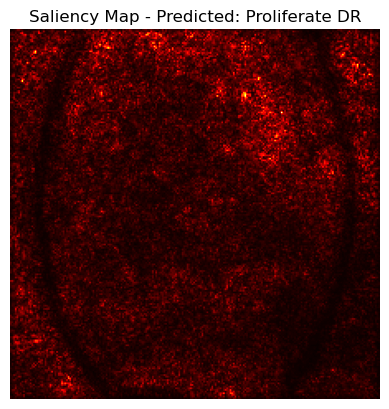

In [2]:
# Test on sample image
predict_sample(r"C:\Users\vishal kumar\Desktop\dataset\diabetic retinopathy\Proliferate DR\Proliferate DR_18.png")